In [1]:
import numpy as np
import pandas as pd
from numpy import pi
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
from random import randint
from qiskit.providers.aer import noise
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
from qiskit.quantum_info.operators import Operator, Pauli

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_16_melbourne') #ibmq_burlington ibmq_16_melbourne
backend_IBMQ = ibmq_provider.get_backend('ibmqx2')
properties = backend_IBMQ.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = backend_IBMQ.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\Users\Niels\Envs\dev_qiskit\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


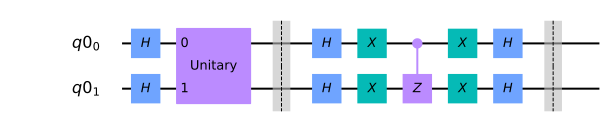

In [2]:
dim = 2
z= QuantumRegister(dim)
qc_expected = QuantumCircuit(z)
qc_expected.h(range(dim))
qreg = QuantumCircuit(z)
# creating a randomized Grover operator
a = randint(0,2**dim-1)
A = np.identity(2**dim)
A[a,a] = -1
print(A)
Grov = Operator(A)
qc_expected.append(Grov,range(dim))

qc_expected.barrier()
qc_expected.h(range(dim))
qc_expected.x(range(dim))

qc_expected.cz(0,1)
qc_expected.x(range(dim))
qc_expected.h(range(dim))
qc_expected.barrier()
qc_expected.draw(output='mpl')

The expected state is: [-1.00000000e+00+2.44929360e-16j  1.06737325e-48+8.71576399e-33j
  0.00000000e+00-2.46519033e-32j -1.06737325e-48-8.71576399e-33j]


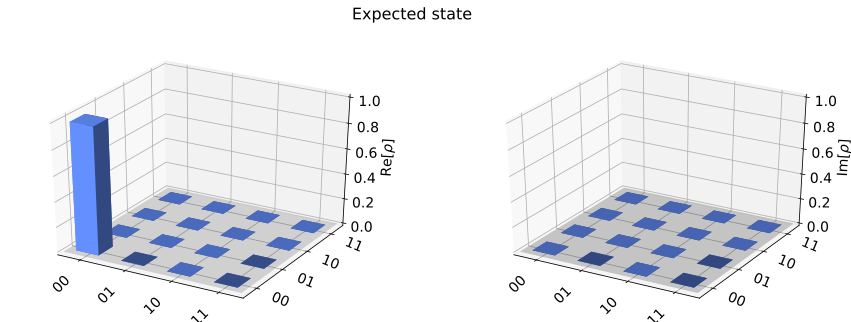

In [3]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

In [4]:
#mitigation measurement
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = qc_expected.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0,
                 )
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


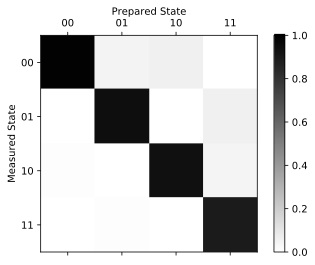

In [5]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

In [6]:
backends = [simulator, device,0]
bits = ['00', '10', '01', '11']
paulis = [('X','X'),('Y','X'),('Z','X'),
          ('X','Y'),('Y','Y'),('Z','Y'),
          ('X','Z'),('Y','Z'),('Z','Z')]
result =[0,0,0,0]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
x=0
for be in backends:
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '10': 0,'01': 0, '11': 0}})
    qst_circuit = state_tomography_circuits(qc_expected,z)
    if be == device or be == simulator:
        job = qiskit.execute(qst_circuit, be, shots=1000)
    print('Done job.')
    if be == device:
        job_monitor(job)
        result[x] = job.result()
        x=x+1
    if be == 0:
        tom = StateTomographyFitter(meas_filter.apply(result[x]),qst_circuit)
        x=x+1
    else:
        tom = StateTomographyFitter(job.result(), qst_circuit)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    y=0
    for bas in basis:
        state.update({bas: {'00': state[bas]['00']+tom.data[paulis[y]][bits[0]],
                                '10': state[bas]['10']+tom.data[paulis[y]][bits[1]],
                                '01': state[bas]['01']+tom.data[paulis[y]][bits[2]],
                                '11': state[bas]['11']+tom.data[paulis[y]][bits[3]]}})
        y=y+1 
    if be == simulator:
        state_sim = state
        print('The full state for simulator is', state)
    if be == device:
        state_dev = state
        print('The full state for device is', state)
        x=0
    if be == 0:
        state_err = state
        print('The corrected state for device is', state)

Done job.
The full state for simulator is {'XX': {'00': 261, '10': 236, '01': 239, '11': 264}, 'YX': {'00': 241, '10': 265, '01': 243, '11': 251}, 'ZX': {'00': 502, '10': 498, '01': 0, '11': 0}, 'XY': {'00': 243, '10': 239, '01': 254, '11': 264}, 'YY': {'00': 242, '10': 250, '01': 249, '11': 259}, 'ZY': {'00': 494, '10': 506, '01': 0, '11': 0}, 'XZ': {'00': 477, '10': 0, '01': 523, '11': 0}, 'YZ': {'00': 511, '10': 0, '01': 489, '11': 0}, 'ZZ': {'00': 1000, '10': 0, '01': 0, '11': 0}}
Done job.
Job Status: job has successfully run
The full state for device is {'XX': {'00': 258, '10': 200, '01': 289, '11': 253}, 'YX': {'00': 325, '10': 254, '01': 227, '11': 194}, 'ZX': {'00': 536, '10': 424, '01': 22, '11': 18}, 'XY': {'00': 261, '10': 185, '01': 324, '11': 230}, 'YY': {'00': 346, '10': 251, '01': 225, '11': 178}, 'ZY': {'00': 557, '10': 404, '01': 22, '11': 17}, 'XZ': {'00': 460, '10': 18, '01': 509, '11': 13}, 'YZ': {'00': 559, '10': 12, '01': 416, '11': 13}, 'ZZ': {'00': 953, '10': 1

In [7]:
# fidelity processing for sim and dev
XXPaul = np.matrix('0,0,0,1;0,0,1,0;0,1,0,0;1,0,0,0')
XYPaul = np.matrix('0,0,0,0-1j;0,0,0+1j,0;0,0-1j,0,0;0+1j,0,0,0')
XZPaul = np.matrix('0,0,1,0;0,0,0,-1;1,0,0,0;0,-1,0,0')
Iden = np.matrix('1,0,0,0;0,1,0,0;0,0,1,0;0,0,0,1')
YXPaul = np.matrix('0,0,0,0-1j;0,0,0-1j,0;0,0+1j,0,0;0+1j,0,0,0')
YYPaul = np.matrix('0,0,0,-1;0,0,1,0;0,1,0,0;-1,0,0,0')
YZPaul = np.matrix('0,0,0-1j,0;0,0,0,0+1j;0+1j,0,0,0;0,0-1j,0,0')
ZXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,-1;0,0,-1,0')
ZYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0+1j;0,0,0-1j,0')
ZZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,-1,0;0,0,0,1')
IXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,1;0,0,1,0')
IYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0-1j;0,0,0+1j,0')
IZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,1,0;0,0,0,-1')
XIPaul = np.matrix('0,0,1,0;0,0,0,1;1,0,0,0;0,1,0,0')
YIPaul = np.matrix('0,0,0-1j,0;0,0,0,0-1j;0+1j,0,0,0;0,0+1j,0,0')
ZIPaul = np.matrix('1,0,0,0;0,1,0,0;0,0,-1,0;0,0,0,-1')

# simulator Bloch vector
r_sim=[0,0,0,0,0,0,0,0,0]
ri_sim=[0,0,0,0,0,0,0,0,0]
ri2_sim=[0,0,0,0,0,0,0,0,0]
riav_sim=[0,0,0]
riav2_sim=[0,0,0]
state_tot=[state_sim,state_dev,state_err]
rho=[0,0,0]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
t=0
for stat in state_tot:
    r=0
    for bas in basis:
        r_sim[r] = (stat[bas]['00']*1 + stat[bas]['10']*(-1)+stat[bas]['01']*(-1)+stat[bas]['11']*1)/(stat[bas]['00']*1 + stat[bas]['10']*(1)+stat[bas]['01']*(1)+stat[bas]['11']*1)
        ri_sim[r] = (stat[bas]['00']*1 + stat[bas]['10']*(1)+stat[bas]['01']*(-1)+stat[bas]['11']*(-1))/(stat[bas]['00']*1 + stat[bas]['10']*(1)+stat[bas]['01']*(1)+stat[bas]['11']*1)
        r=r+1
    basis2 = ['XX','XY','XZ','YX','YY','YZ','ZX','ZY','ZZ']
    r=0
    for bas in basis2:
        ri2_sim[r] = (stat[bas]['00']*1 + stat[bas]['10']*(-1)+stat[bas]['01']*(1)+stat[bas]['11']*(-1))/(stat[bas]['00']*1 + stat[bas]['10']*(1)+stat[bas]['01']*(1)+stat[bas]['11']*1)
        r=r+1
    for i in range(0,3):
        riav_sim[i]=(ri_sim[3*i]+ri_sim[3*i+1]+ri_sim[3*i+2])/3
        riav2_sim[i]=(ri2_sim[3*i]+ri2_sim[3*i+1]+ri2_sim[3*i+2])/3
    rho[t] = (1/4)*(Iden+r_sim[0]*XXPaul+r_sim[1]*XYPaul+r_sim[2]*XZPaul+
                 r_sim[3]*YXPaul+r_sim[4]*YYPaul+r_sim[5]*YZPaul+
                 r_sim[6]*ZXPaul+r_sim[7]*ZYPaul+r_sim[8]*ZZPaul+
                 ri_sim[0]*IXPaul+ri2_sim[0]*XIPaul+ri_sim[4]*IYPaul+
                 ri2_sim[4]*YIPaul+ri_sim[8]*IZPaul+ri2_sim[8]*ZIPaul)
    t=t+1

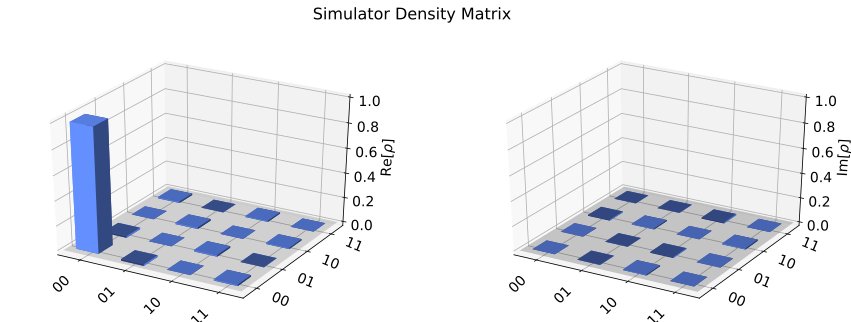

In [8]:
plot_state_city(rho[0], title='Simulator Density Matrix')

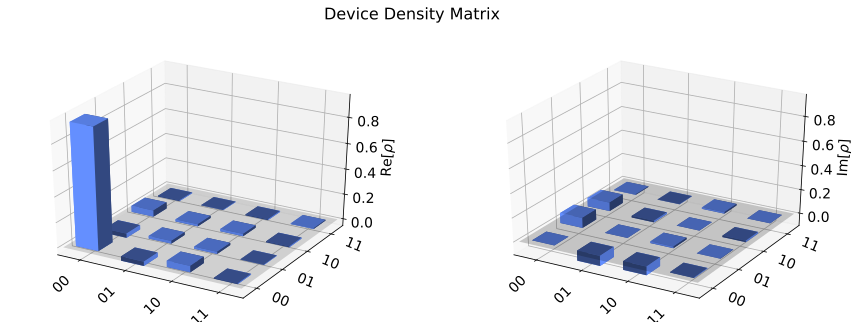

In [9]:
plot_state_city(rho[1], title='Device Density Matrix')

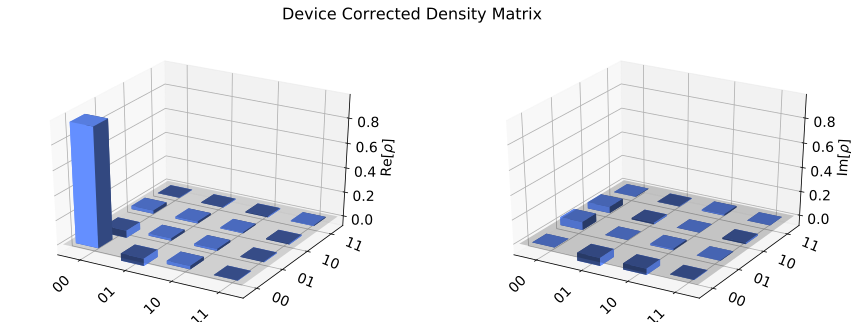

In [10]:
plot_state_city(rho[2], title='Device Corrected Density Matrix')

In [11]:
Sim_Fidelity = state_fidelity(psi_expected, rho[0], validate=False)
Dev_Fidelity = state_fidelity(psi_expected, rho[1], validate=False)
Err_Fidelity = state_fidelity(psi_expected, rho[2], validate=False)
print('Simulation Fidelity:', Sim_Fidelity)
print('Device Fidelity:', Dev_Fidelity)
print('Corrected Device Fidelity:', Err_Fidelity)

Simulation Fidelity: 1.0000000000000004
Device Fidelity: 0.9530000000000005
Corrected Device Fidelity: 0.9646278959437511
